# Desafio - Beaver / Rogerio

Em anexo está um arquivo que contém várias linhas de texto extraídas de matrículas de imóveis usando um OCR. Ao final de cada parágrafo/cláusula, eu inseri um marcador ("<--split-->"). O que eu queria que você fizesse era tentar criar um modelo que estimasse a probabilidade de uma linha ser a última do parágrafo (e portanto quando que este marcador deveria aparecer). Sugiro que você separe o arquivo em dois pedaços, um que você vai usar para treinar o modelo, e outro para testá-lo.<br /><br />
Você pode usar as ferramentas que quiser, mas acredito que usando apenas pandas e regressão logística você já consiga fazer alguma coisa. Não se preocupe em tentar usar ferramentas mais sofisticadas de NLP. Você vai precisar construir os parâmetros que vai passar para o modelo.<br /><br />

## Informações do Projeto

Inicialmente optei por utilizar algo relacionado ao Teorema de Bayes, mais especificamente o Classificador Naive-Bayes, que é largamente utilizado em filtros anti-spam de e-mails. O classificador permite calcular qual a probabilidade de uma mensagem/frase ser relevante em função das palavras em seu conteúdo.<br /><br />
Para realizar o MVP (*minimum viable product*) do projeto, implementei uma versão do classificador que "aprende" o que é relevante com uma base de treinamento e compara a performance dos resultados com uma base de testes.<br /><br />
Após validado, o protótipo poderá também capturar e classificar automaticamente as frases de parágrafos e cláusulas da plataforma.

Algumas leituras realizadas:<br />
* https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/
* http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.65.9324&rep=rep1&type=pdf
* http://minerandodados.com.br/index.php/2018/04/04/spotify-svm-python/ (menos relevante)

___
## Montando o Classificador Naive-Bayes

Com a base de treinamento montada, comecei a desenvolver o classificador, implementando, inclusive, o Laplace Smoothing.

In [1]:
#importando bibliotecas
%matplotlib inline
import pandas as pd
import numpy as np
import math as math
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt

RANDOM_SEED = 42 #retornar sempre a mesma amostra aleatoria, para fins de teste

np.random.seed(RANDOM_SEED)

In [2]:
#Leitura do arquivo linhas.txt 
linhas = pd.read_fwf('linhas.txt', header = None, encoding = "utf_8")
# linhas = pd.read_table('linhas.txt', header = None)8
linhas

,0
0,"M. 96.079 - A UNIDADE 03, de alvenaria, do Con..."
1,"Vista, sob nº 230 da rua Getúlio Celso Nunes, ..."
2,para a direita de quem da referida rua olhar o...
3,"pátio, sala, cozinha, área de serviço, circula..."
4,dormitórios; com área real privativa e total c...
...,...
2934,Selo de Fiscalização Eletrônico Nº ECPR 95022 ...
2935,fé . Aux. Resp. 00 - ficlay. ARTHON. CARLOS. M...
2936,Carlos Fernando dos Santos - Substituto
2937,() Luiz Eduardo Carvalho da Silva - Substituto


In [3]:
#alterando nome da coluna para facilitar o entendimento
linhas.rename(columns={linhas.columns[-1]:'Linhas'}, inplace=True)
linhas.head()

,Linhas
0,"M. 96.079 - A UNIDADE 03, de alvenaria, do Con..."
1,"Vista, sob nº 230 da rua Getúlio Celso Nunes, ..."
2,para a direita de quem da referida rua olhar o...
3,"pátio, sala, cozinha, área de serviço, circula..."
4,dormitórios; com área real privativa e total c...


Com o dataframe limpo e sem bugs, pensei, inicialmente, em analisar se a linha acabava com uma pontuação. Porém, ao ler o arquivo texto mais a fundo, notei que nem sempre uma cláusula/parágrafo acabava com pontuações. 
Portanto, o modelo deveria se basear nas palavras e como estão estruturadas (letras maiúsculas e minúsculas, frequência, etc).

Frequência de palavras (principal fonte de treinamento do modelo): 
* Mais frequentes no final de uma cláusula/parágrafo (PARTE 1)<br />
* Mais frequentes no começo de uma cláusula/parágrafo (PARTE 2)

Letras maiúsculas e minúsculas (indiretamente acoplada na análise das palavras dos itens acima):
* Estado das letras das palavras do começo de uma cláusula/parágrafo.<br />
* Estado das letras das palavras do final de uma cláusula/parágrafo. (PELO "OLHÔMETRO", NÃO IDENTIFIQUEI NENHUMA RELAÇÃO)

## Scikit-Learn

Já que a principal biblioteca para Machine Learning em Python chama-se Scikit-Learn, ou de modo abreviado `sklearn`, e com esta biblioteca podemos construir modelos de aprendizado de máquina bem sofisticados, exceto para *deep learning*, onde outras bibliotecas são usadas (e.g. Keras, Theano, TensorFlow), decidi fazer o uso dessa biblioteca para classificação de frases via Naive Bayes.

Caso nunca tenha usado `sklearn` na sua máquina, só instalar com o comando:

```conda install scikit-learn```

Informações retiradas de http://scikit-learn.org/stable/

### Parte 1 - Mais frequentes no FINAL de uma cláusula/parágrafo.
___

Antes de começar a montar o classificador, serão necessárias 2 colunas: uma destinada à classificação e outra destinada ao conteúdo:

In [4]:
#criando coluna a respeito da classificação das frases: SIM (caso seja a última) e NÃO (caso contrário)
linhas["Classificação"] = "NaN"
for e in range(1,len(linhas)):
    if linhas.iloc[e]["Linhas"] == "<--split-->":
        linhas["Classificação"][e-1] = "Sim"
    else:
        linhas["Classificação"][e-1] = "Não"
linhas.head()

,Linhas,Classificação
0,"M. 96.079 - A UNIDADE 03, de alvenaria, do Con...",Não
1,"Vista, sob nº 230 da rua Getúlio Celso Nunes, ...",Não
2,para a direita de quem da referida rua olhar o...,Não
3,"pátio, sala, cozinha, área de serviço, circula...",Não
4,dormitórios; com área real privativa e total c...,Não


Além de uma coluna de classificação, para que o Scikit Learn funcione, serão necessários 2 DataFrames: o que será usado para treinamento e o que será usado para teste. Assim, dividi as 2939 rows que temos em 3, ficando 2/3 (1960) para treinamento e 1/3 (979) para testes.

O `sklearn` já tem uma função para:

- Embaralhar as amostras de exemplo, e
- Separar os conjuntos de treinamento e teste.

In [5]:
from sklearn.model_selection import train_test_split
linhas_1 = linhas[(linhas["Linhas"]!="<--split-->")]
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(linhas_1["Linhas"], linhas_1["Classificação"], test_size=0.33, random_state=RANDOM_SEED)

Construindo um classificador Naive-Bayes e treinando-o com o conjunto de treinamento:

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Cria modelo.
model_1 = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("classifier", MultinomialNB())
])

# Treina modelo.
model_1.fit(X_train_1, y_train_1)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', MultinomialNB())])

Testando a acurácia do modelo:

In [7]:
# Testando modelo.
y_pred_1 = model_1.predict(X_test_1)

# Calculando acurácia.
acc_1 = accuracy_score(y_test_1, y_pred_1)

print("Acurácia: {}".format(acc_1))

Acurácia: 0.9338478500551268


### Parte 2 - Mais frequentes no COMEÇO de uma cláusula/parágrafo.
___

In [8]:
#criando coluna a respeito da classificação das frases: SIM (caso seja a primeira) e NÃO (caso contrário)
linhas["Classificação"] = "NaN"
for e in range(-1,len(linhas)):
    if linhas.iloc[e]["Linhas"] == "<--split-->":
        linhas["Classificação"][e+1] = "Sim"
    else:
        linhas["Classificação"][e+1] = "Não"
linhas.head()

,Linhas,Classificação
0,"M. 96.079 - A UNIDADE 03, de alvenaria, do Con...",Sim
1,"Vista, sob nº 230 da rua Getúlio Celso Nunes, ...",Não
2,para a direita de quem da referida rua olhar o...,Não
3,"pátio, sala, cozinha, área de serviço, circula...",Não
4,dormitórios; com área real privativa e total c...,Não


In [9]:
#separando amostras de treinamento e teste
linhas_2 = linhas[(linhas["Linhas"]!="<--split-->")]
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(linhas_2["Linhas"], linhas_2["Classificação"], test_size=0.33, random_state=RANDOM_SEED)

In [10]:
# Cria modelo.
model_2 = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("classifier", MultinomialNB())
])

# Treina modelo.
model_2.fit(X_train_2, y_train_2)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', MultinomialNB())])

In [11]:
# Testando modelo.
y_pred_2 = model_2.predict(X_test_2)

# Calculando acurácia.
acc_2 = accuracy_score(y_test_2, y_pred_2)

print("Acurácia: {}".format(acc_2))

Acurácia: 0.9636163175303197


### Visto a alta acurácia obtida no treinamento de ambos os modelos acima, podemos mesclar ambos para testar novas frases de uma cláusula/parágrafo:

Dado os seguinte parágrafos, onde entrariam o marcador `<--split-->`?

`0`M. 96.079 - A UNIDADE 03, de alvenaria, do Condomínio Residencial Boa<br />
`1`Vista, sob nº 230 da rua Getúlio Celso Nunes, a terceira da esquerda <br />
`2`para a direita de quem da referida rua olhar o conjunto, composta de: <br />
`3`pátio, sala, cozinha, área de serviço, circulação, banho e dois <br />
`4`dormitórios; com área real privativa e total construída de 51,42m2, <br />
`5`correspondendo - lhe a ' fração ideal de 0,201442 no terreno e nas demais <br />
`6`coisas de uso comum e fim proveitoso do condomínio. A esta unidade <br />
`7`corresponde um terreno privativo constituido de parte dos lotes 01 e <br />
`8`06, com a área superficial de 81,60m2, medindo 6,8 Om de frente ao Sul, <br />
`9`à rua Getúlio Celso Nunes; nos fundos ao Norte com a mesma largura da <br />
`10`frente entesta com parte dos lotes 02 e 05; por 12,00m de extensão da <br />
`11`frente aos fundos em ambos os lados, dividindo - se por um lado ao Oeste <br />
`12`com o terreno da Unidade 02 e pelo outro lado ao Leste divide - se com <br />
`13`o terreno da Unidade 04, distante 16,60m da esquina com a Travessa <br />
`14`o terreno sobre o qual está edificado o condomínio constituí - se dos <br />
`15`lotes 01 e 06 da quadra 12, com a área superficial de 480,00m, <br />
`16`situado no loteamento denominado JARDIM TIMBAÚVA, neste município, <br />
`17`medindo 12,00m de frente a Oeste à Travessa Final, nos fundos a Leste <br />
`18`com a mesma largura da frente entesta com a Travessa Verde, com a qual <br />
`19`tambérn faz frente, por 40,00m de extensão da frente ao fundo em ambos. <br />
`20`os lados, dividindo - se por um lado ao Sul com a rua Getúlio Celso <br />
`21`Nunes, com a qual também faz frente e forma esquina e pelo outro lado <br />
`22`ao Norte divide - se com os lotes 02 e 05. Quarteirão: rua Getúlio Celso <br />
`23`Nunes, Travessa Final, Travessa Verde e terras que são ou foram de <br />
`24`João Deres Ortiz. Origem: matricula nº 90.720 de 03.02.2013. <br />
`25`Proprietária: HOFFMANN & BORGES CONSTRUÇÕES LTDA, inscrita no WNPJ nº <br />
`26`12.933.936/0001-54, com sede na rua Brito Peixoto, n° 2do, Bairro <br />
`27`Neópolis, em Gravataí / RS.<br />
`28`COMPRA E VENDA: Instrumento particular firmado em 06.01.2014 <br />
`29`TRANSMITENTE: HOFFMANN & BORGES CONSTRUÇÕES LTDA, já qualificada. <br />
`30`ADQUIRENTE: PAULA MARA FRIEDRICH, brasileira, solteira, maior, gerente <br />
`31`de compras, inscrita no CPF n° 812.072.390-20, não matriculada no INSS <br />
`32`como empregadora, residente e domiciliada na rua Luiz Linck Barcelos, <br />
`33`n° 45, bairro Jardim Timbaúva, em Gravataí / RS. <br />
`34`VALOR: R$ 128.000,00 <br />

`RESPOSTA`: DEPOIS DAS ROWS 27 E 34 / ANTES DAS ROWS 28 E 35

In [12]:
paragrafo_teste = linhas.iloc[0:35]
PosicaoMarcador = []
for e in range(1,len(paragrafo_teste)):
    if model_1.predict([paragrafo_teste.iloc[e-1]["Linhas"]]) == "Sim" and model_2.predict([paragrafo_teste.iloc[e]["Linhas"]]) == "Sim":
        PosicaoMarcador.append("depois da row de numero {}".format(e-1))
        
print(PosicaoMarcador)

[]


In [13]:
model_1.predict(["Neópolis, em Gravataí / RS."])

array(['Não'], dtype='<U3')

In [14]:
model_2.predict(["COMPRA E VENDA: Instrumento particular firmado em 06.01.2014 "])

array(['Não'], dtype='<U3')

### Ao testar o modelo, percebi que, apesar de sua acurácia muito alta, ele não estava eficaz o suficiente e uma possível explicação para isso seria a alta quantidade de "Não" em relação a "Sim" no modelo, tornando a base de treinamento "enviesada". Dessa maneira, optei por criar amostras aleatórias de tamanhos iguais para os dois tipos de classificação da base de dados.

___
### Refazendo Parte 1 para eliminar o  viés

In [15]:
#criando coluna a respeito da classificação das frases: SIM (caso seja a última) e NÃO (caso contrário)
linhas["Classificação"] = "NaN"
for e in range(1,len(linhas)):
    if linhas.iloc[e]["Linhas"] == "<--split-->":
        linhas["Classificação"][e-1] = "Sim"
    else:
        linhas["Classificação"][e-1] = "Não"
linhas_1_SemSplit = linhas[(linhas["Linhas"]!="<--split-->")]

Separando o dataframe classficado antes do treinamento em dois (sim e não):

In [16]:
#separando dataframes por classificação
linhas_sim_1 = linhas_1_SemSplit[(linhas_1_SemSplit["Classificação"]=="Sim")]
linhas_nao_1 = linhas_1_SemSplit[(linhas_1_SemSplit["Classificação"]=="Não")]
print(linhas_sim_1.shape, linhas_nao_1.shape)

(193, 2) (2553, 2)


Acima dá para perceber claramente a diferença grotesca no tamanho de dados referentes a cada classificação (193 "Sim" VS 2553 "Não"). Portanto, diminuirei aleatoriamente a amostra de "Não" para que fique do tamanho da de "Sim".

In [17]:
#diminuindo amostra de "Não" aleatoriamente
linhas_nao_1_random = linhas_nao_1.sample(frac = len(linhas_sim_1)/len(linhas_nao_1), random_state=RANDOM_SEED)
linhas_nao_1_random.shape

(193, 2)

Com a amostra de "Não" reduzida aleatoriamente para o tamanho de "Sim", podemos juntar os dois para criar a base de dados que alimentará o treinamento do modelo:

In [18]:
#juntando as amostras de "Sim" e "Não"
linhas_SemVies_1 = linhas_sim_1.append(linhas_nao_1_random)
linhas_SemVies_1.head()

,Linhas,Classificação
27,"Neópolis, em Gravataí / RS.",Sim
35,"VALOR: R$ 128.000,00",Sim
40,Protocolo n° 287.246 de 14.01.2014.,Sim
44,"mesma, no valor de R$ 100.000,00.",Sim
49,recolhimento do imposto de transmissão.,Sim


In [19]:
#embaralhando aleatoriamente a base de dados
linhas_1_random = linhas_SemVies_1.sample(frac = 1, random_state=RANDOM_SEED)
linhas_1_random.head()

,Linhas,Classificação
162,"domiciliado na Rua Virginia V. Masotti, nº C25...",Não
2824,"cônjuge SHEILA DOS SANTOS TAVARES, nacionalida...",Não
1259,"hoje se archivajo de Janeiro, 22 de Agosto de ...",Sim
496,"HENRIQUE FRAGA ANTUNES DE SOUZA, brasileiro, s...",Não
2195,"Aleluia, Oficial Substituta. Eu, Clerilda Lima...",Sim


Tendo a base de dados enviesada e embaralhada, posso iniciar o treinamento do modelo:

In [20]:
#separando a base de dados aleatória e sem viés em treinamento e teste
X_train_1_SemVies, X_test_1_SemVies, y_train_1_SemVies, y_test_1_SemVies = train_test_split(linhas_1_random["Linhas"], linhas_1_random["Classificação"], test_size=0.33, random_state=RANDOM_SEED)

In [21]:
# Cria modelo.
model_1_SemVies = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("classifier", MultinomialNB())
])

# Treina modelo.
model_1_SemVies.fit(X_train_1_SemVies, y_train_1_SemVies)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', MultinomialNB())])

In [22]:
# Testando modelo.
y_pred_1_SemVies = model_1_SemVies.predict(X_test_1_SemVies)

# Calculando acurácia.
acc_1_SemVies = accuracy_score(y_test_1_SemVies, y_pred_1_SemVies)

print("Acurácia: {}".format(acc_1_SemVies))

Acurácia: 0.8203125


___
### Refazendo Parte 2 para eliminar o viés

In [23]:
#criando coluna a respeito da classificação das frases: SIM (caso seja a primeira) e NÃO (caso contrário)
linhas["Classificação"] = "NaN"
for e in range(-1,len(linhas)):
    if linhas.iloc[e]["Linhas"] == "<--split-->":
        linhas["Classificação"][e+1] = "Sim"
    else:
        linhas["Classificação"][e+1] = "Não"
linhas_2_SemSplit = linhas[(linhas["Linhas"]!="<--split-->")]

In [24]:
#separando dataframes por classificação
linhas_sim_2 = linhas_2_SemSplit[(linhas_2_SemSplit["Classificação"]=="Sim")]
linhas_nao_2 = linhas_2_SemSplit[(linhas_2_SemSplit["Classificação"]=="Não")]
print(linhas_sim_2.shape, linhas_nao_2.shape)

(193, 2) (2553, 2)


In [25]:
#diminuindo amostra de "Não" aleatoriamente
linhas_nao_2_random = linhas_nao_2.sample(frac = len(linhas_sim_2)/len(linhas_nao_2), random_state=RANDOM_SEED)
linhas_nao_2_random.shape

(193, 2)

In [26]:
#juntando as amostras de "Sim" e "Não"
linhas_SemVies_2 = linhas_sim_2.append(linhas_nao_2_random)
linhas_SemVies_2.head()

,Linhas,Classificação
0,"M. 96.079 - A UNIDADE 03, de alvenaria, do Con...",Sim
29,COMPRA E VENDA: Instrumento particular firmado...,Sim
37,CÉDULA DE CRÉDITO IMOBILIÁRIO INTEGRAL: Foi em...,Sim
42,Av. 4/96.079 - Conforme campo 11 da cédula ant...,Sim
46,CONSOLIDACÃO DA PROPRIEDADE: Requerimento firm...,Sim


In [27]:
#embaralhando aleatoriamente a base de dados
linhas_2_random = linhas_SemVies_2.sample(frac = 1, random_state=RANDOM_SEED)
linhas_2_random.head()

,Linhas,Classificação
163,nesta cidade.,Não
2825,"nascida em 28/11/1961, administradora, portado...",Não
1256,AV - 9 M 45.874 - CANCELAMENTO DE CHI5 Fica ca...,Sim
497,portador da carteira de identidade nº 19490208...,Não
2183,Data: 30 de Abril de 2009. IMOVEL: Lote de ter...,Sim


In [28]:
#separando a base de dados inviezada e aleatória em 2
from sklearn.model_selection import train_test_split
X_train_2_SemVies, X_test_2_SemVies, y_train_2_SemVies, y_test_2_SemVies = train_test_split(linhas_2_random["Linhas"], linhas_2_random["Classificação"], test_size=0.33, random_state=RANDOM_SEED)

In [29]:
# Cria modelo.
model_2_SemVies = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("classifier", MultinomialNB())
])

# Treina modelo.
model_2_SemVies.fit(X_train_2_SemVies, y_train_2_SemVies)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', MultinomialNB())])

In [30]:
# Testando modelo.
y_pred_2_SemVies = model_2_SemVies.predict(X_test_2_SemVies)

# Calculando acurácia.
acc_2_SemVies = accuracy_score(y_test_2_SemVies, y_pred_2_SemVies)

print("Acurácia: {}".format(acc_2_SemVies))

Acurácia: 0.765625


___
Com as acurácias obtidas a partir dos 4 modelos, podemos concluir algumas coisas:
* Apesar da acurácia do modelo ter diminuido, ela perdeu seu viés, tornando o modelo mais real;
* Permite conclusões mais apuradas sobre o modelo;
* Há menos chances de chutar sempre "Não" para qualquer linha.

In [31]:
#TESTANDO PARA AMBOS OS MODELOS SEM VIÉS TRABALHANDO SIMULTANEAMENTE
paragrafo_teste = linhas.iloc[0:35]
PosicaoMarcador = []
for e in range(0,len(paragrafo_teste)):
    if model_1_SemVies.predict([paragrafo_teste.iloc[e]["Linhas"]]) == "Sim" and model_2_SemVies.predict([paragrafo_teste.iloc[e+1]["Linhas"]]) == "Sim":
        PosicaoMarcador.append("depois da row de numero {}".format(e-1))
        
print(PosicaoMarcador)

['depois da row de numero 22', 'depois da row de numero 26', 'depois da row de numero 27']


In [32]:
#TESTANDO PARA LINHA FINAL INDIVIDUALMENTE
model_1_SemVies.predict(["Neópolis, em Gravataí / RS."])

array(['Sim'], dtype='<U3')

In [33]:
#TESTANDO PARA LINHA INICIAL INDIVIDUALMENTE
model_2_SemVies.predict(["M. 96.079 - A UNIDADE 03, de alvenaria, do Condomínio Residencial Boa"])

array(['Sim'], dtype='<U3')

In [34]:
#TESTANDO PARA O MODELO DA LINHA DO FINAL DO PARÁGRAFO INDIVIDUALMENTE
paragrafo_teste = linhas.iloc[0:35]
PosicaoMarcador = []
for e in range(0,len(paragrafo_teste)):
    if model_1_SemVies.predict([paragrafo_teste.iloc[e]["Linhas"]]) == "Sim":
        PosicaoMarcador.append("depois da row de numero {}".format(e))
        
print(PosicaoMarcador)

['depois da row de numero 23', 'depois da row de numero 24', 'depois da row de numero 27', 'depois da row de numero 28']


In [35]:
#TESTANDO PARA O MODELO DA LINHA DO COMEÇO DO PARÁGRAFO INDIVIDUALMENTE
paragrafo_teste = linhas.iloc[0:35]
PosicaoMarcador = []
for e in range(0,len(paragrafo_teste)):
    if model_2_SemVies.predict([paragrafo_teste.iloc[e]["Linhas"]]) == "Sim":
        PosicaoMarcador.append("antes da row de numero {}".format(e))
        
print(PosicaoMarcador)

['antes da row de numero 0', 'antes da row de numero 23', 'antes da row de numero 24', 'antes da row de numero 28', 'antes da row de numero 29', 'antes da row de numero 30', 'antes da row de numero 31']


Agora que vi que os dois modelos pararam de retornar somente chutes aleatórios de "Não" podemos descobrir a verdadeira acurácia de um modelo que utiliza a classificação de linhas de parágrafos/cláusulas usando ambos os métodos. Ou seja, vamos refazer o teste novamente aplicando os dois modelos (últimas e primeiras linhas) simultâneamente e testar novamente sua acurácia. Para refazer os testes:

* Mantive a coluna "Classificação" (Sim para linhas finais de parágrafo e Não para o contrário);
* Criei uma coluna "Teste" para meu modelo determinar quais linhas serão ou não as últimas das cláusulas.

In [36]:
linhas = pd.read_fwf('linhas.txt', header = None, encoding = "utf_8")
linhas.rename(columns={linhas.columns[-1]:'Linhas'}, inplace=True)
linhas["Classificação"] = "NaN"
for e in range(1,len(linhas)):
    if linhas.iloc[e]["Linhas"] == "<--split-->":
        linhas["Classificação"][e-1] = "Sim"
    else:
        linhas["Classificação"][e-1] = "Não"

In [37]:
linhas["Teste"] = "NaN"
for e in range(0,len(linhas)-1):
    if model_1_SemVies.predict([linhas.iloc[e]["Linhas"]]) == "Sim" and model_2_SemVies.predict([linhas.iloc[e+1]["Linhas"]]) == "Sim":
        linhas["Teste"][e] = "Sim"
    else:
        linhas["Teste"][e] = "Não"
linhas.head()

,Linhas,Classificação,Teste
0,"M. 96.079 - A UNIDADE 03, de alvenaria, do Con...",Não,Não
1,"Vista, sob nº 230 da rua Getúlio Celso Nunes, ...",Não,Não
2,para a direita de quem da referida rua olhar o...,Não,Não
3,"pátio, sala, cozinha, área de serviço, circula...",Não,Não
4,dormitórios; com área real privativa e total c...,Não,Não


Com as colunas "Classificação" (real) e "Teste" (meu modelo):
* Para manter um padrão de comparação, separei apenas as linhas usadas no teste da PARTE 1 SEM VIÉS
* Obtive a quantidade de matches
* Com os "matches" quantificados, calculei a acurácia do meu modelo (matches/total)

In [38]:
#analisando quais rows correspondiam ao teste da parte 1 sem viés
y_test_1_SemVies.head()

2034    Não
375     Não
2663    Não
1177    Não
2480    Não
Name: Classificação, dtype: object

In [39]:
#separando as rows obtidas acima
linhas_final = linhas.iloc[[2034,
375,
2663,
1177,
2480,
962,
2884,
204,
2602,
1714,
220,
1540,
130,
498,
2406,
1097,
2032,
44,
2470,
143,
1955,
1676,
109,
461,
1305,
1200,
1234,
2356,
1645,
162,
1671,
2513,
176,
701,
2001,
2665,
530,
1718,
679,
226,
713,
1618,
746,
577,
315,
207,
2627,
2674,
2460,
1132,
2802,
2805,
1658,
1055,
2224,
2393,
332,
2420,
1932,
1613,
1915,
1455,
828,
2158,
1380,
1603,
1170,
1412,
187,
671,
939,
1521,
496,
2128,
2579,
2446,
1034,
2350,
889,
1242,
2902,
2528,
365,
2493,
1852,
1270,
2430,
404,
957,
1225,
1005,
1836,
1431,
2923,
1290,
1488,
2462,
1381,
285,
2070,
2453,
150,
1273,
1021,
447,
1944,
1438,
2495,
1389,
1392,
2255,
1155,
2181,
1769,
1077,
2409,
2450,
768,
1248,
1554,
1884,
1211,
1395,
2557,
1327,
1062,
1627,
2273],]
linhas_final

,Linhas,Classificação,Teste
2034,diversas clausulas do contrato inscrito e sem ...,Não,Não
375,Prenotado no Livro 1 - T sob n° 73.543 em 12/0...,Não,Não
2663,"acima, DEU EM GARANTIA DE ALIENAÇÃO FIDUCIÁRIA...",Não,Não
1177,"amarrador, inscrito no CPF nº 023.308.260-36, ...",Não,Não
2480,"Schinatto e a segunda por 1,85 metros, com par...",Não,Não
...,...,...,...
2557,"0133.01.1400029 02881 R$ 0,30 - Nos termos da ...",Sim,Sim
1327,"cidade, CNPJ / MF sob o nº 00.360.305/0001-04,...",Não,Não
1062,"R$ 4,20 da Lei 6281/12. São Gonçalo, 28 de mar...",Sim,Sim
1627,número de contgbuinte 340.411,Não,Não


In [40]:
#contando os MATCHES entre a classficação real e a obtida pelo meu modelo
matches = 0
for e in range(0,len(linhas_final)):
    if linhas_final.iloc[e]["Classificação"] == linhas_final.iloc[e]["Teste"]:
        matches +=1
print("O número de matches foi de: {0}".format(matches))

O número de matches foi de: 112


In [41]:
#calculando acurácia
acc_final = (matches/len(linhas_final))*100
print("Acurácia: {0}%".format(acc_final))

Acurácia: 87.5%


___
## Concluindo e Possíveis Implementações Futuras

* Comparativo qualitativo sobre as medidas obtidas.<br />
* Algumas melhorias reais no classificador com indicações concretas de como implementar<br />


   Em termos qualitativos de análise dos resultados o programa foi capaz de processar informações sobre os parágrafos e cláusulas recebidos e a partir deles diagnosticar se seria ou não uma linha final com um índice de precisão mais que satisfatório (87.5% de acurácia). Em comparação aos modelos obtidos inicialmente, a mescla de métodos (linhas finais E iniciais) foi uma estratégia bem sucedida por ter apresentado uma acurácia mais próxima do perfeito (100%).

   Com o objetivo de expandir o programa construído seria necessário uma maior amostragem de parágrafos e cláusulas, para que a inteligência do programa conseguisse ter um repertório maior, além de novas formas e métodos para o cálculo de probabilidades com o objetivo de comparar e adequar ao melhor caso possível o melhor método de análise. Com apenas alguns dias de projeto em uma semana corrida na faculdade, fui capaz de realizar um programa eficiente e minimamente funcional, com espaço para aprimoramentos, mas que consegue atender ao propósito de forma efetiva. Visto esse desempenho e o bom planejamento para atingir os próximos objetivos creio estar mais que preparado para novos projetos.

   Quando tratamos de expandir os horizontes e aumentar o alcance do modelo tenho algumas sugestões que, pela falta de tempo, não consegui implementar.

   Com Scikit-Learn é fácil testar outros modelos e ver qual melhor se adequa a esse tipo de dado (https://scikit-learn.org/stable/modules/ensemble.html). 
   
   Poderia experimentar com um modelo chamado "Random Forests" ou "Stochastic Gradient Descent" (mais aplicado em classficações binárias):
* `from sklearn.ensemble import RandomForestClassifier`<br />
* `from sklearn.linear_model import SGDClassifier`

Ou talvez se apropriar de um modelo chamado de "Bagging and Boosting":
* https://becominghuman.ai/ensemble-learning-bagging-and-boosting-d20f38be9b1e
* http://www.cs.ecu.edu/~dingq/CSCI6905/readings/BaggingBoosting.pdf

Talvez ter usado um classificador diferente da `MultinomialNB()`, ou ter classificado por meio de Regressão Logística, como no mock-up não sucedido abaixo:

___
## Teste com Regressão Logística
A probabilidade de que uma amostra pertença à categoria $1$ (ou 'positiva', ou 'relevante', como quiser) seja $p$, e consequentemente a probabilidade de que uma amostra pertença à categoria oposta ($0$, ou 'negativa', ou 'irrelevante, etc) será $1 - p$:

$$Prob(y = 1 | X = x) = p$$

e

$$Prob(y = 0 | X = x) = 1 - p$$

onde $X = (x_1, x_2)$, por exemplo. Podemos representar quão grande é a chance de $y = 1$ em relação à chance de $y = 0$ simplesmente obtendo a razão entre elas (*odds*):

$$odds = \frac{Prob(y = 1 | X = x)}{Prob(y = 0 | X = x)} = \frac{p}{1 - p}$$

Por exemplo, numa roleta de cassino a chance de perder é $36/37$ e a chance de ganhar é $1/37$, logo $odds = 1 \text{ para } 36$. 

No modelo de regressão logística, vamos fazer algo parecido com a regressão linear, mas desta vez a variável dependente será o logaritmo da chance (chamado de "logito"):

$$\log{\left(\frac{p}{1 - p}\right)} = \beta_0 + \beta_1 x_1 + \beta_2 x_2$$

Com um pouco de álgebra (aplica função exponencial dos dois lados, isola $p$) chegamos na seguinte expressão:

$$Prob(y = 1 | X = x) = \frac{1}{1 + e^{-\left(\beta_0 + \beta_1 x_1 + \beta_2 x_2\right)}}$$

Esta função é conhecida como **função logística**. Eis a cara da função logística padrão:

$$f(x) = \frac{1}{1 + e^{-x}}$$

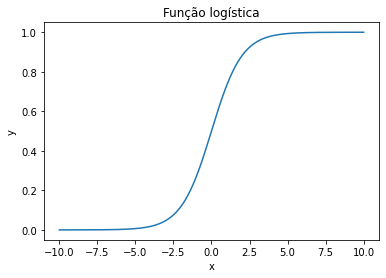

In [42]:
x_logistica = np.linspace(-10, 10, 500)
y_logistica = 1/(1 + np.exp(-x_logistica))

plt.plot(x_logistica, y_logistica)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Função logística');

Para usar este modelo para classificação basta definir um ponto de corte: se $Prob(y = 1 | X = x) > corte$ pode-se dizer que a amostra pertence à classe $1$, caso contrário pertence à classe $0$. Normalmente usa-se $corte = 0.5$.

Treinar o modelo de regressão logística significa ajustar os valores de $\beta_i$ tal que a acurácia seja maximizada. Utilizando novamente o Scikit-Learn: